<a href="https://colab.research.google.com/github/MarcinAn/Przestepczosc/blob/main/Przestepczosc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pobieranie danych**

In [1]:
import pandas as pd
df= pd.read_csv('fatal-police-shootings-data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


**Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).**

In [2]:
import numpy as np
mental_illness = df.pivot_table(values= 'name', index= 'race', columns= 'signs_of_mental_illness', aggfunc= 'count')
mental_illness

signs_of_mental_illness,False,True
race,,
A,69,24
B,1114,184
H,745,157
N,64,14
O,37,11
W,1763,713


**Za pomocą Map, Applymap lub Apply dodaj do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiedz, która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.**

In [3]:
mental_illness_counter= mental_illness.reset_index()
mental_illness_counter


signs_of_mental_illness,race,False,True
0,A,69,24
1,B,1114,184
2,H,745,157
3,N,64,14
4,O,37,11
5,W,1763,713


In [4]:
def mental_illnes_intervention(row):
  return round(row[True]/(row[True]+row[False]), 2)

mental_illness_counter['count'] = mental_illness_counter.apply(lambda row: mental_illnes_intervention(row), axis=1)

<Axes: xlabel='race'>

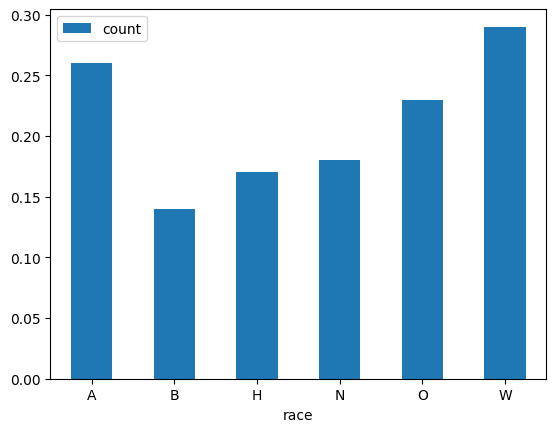

In [5]:
mental_illness_counter.plot.bar(x= 'race', y= 'count', rot= 0)

**Dodaj kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zlicz interwencje według odpowiedniego dnia tygodnia. Następnie stwórz wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.**

In [6]:
df['Day'] = pd.to_datetime(df['date']).dt.day_name()
plot = df.pivot_table(values = 'name', index = {'Day', 'date'}, aggfunc = 'count').reset_index()
plot['Day_nr']= pd.to_datetime(plot['date']).dt.dayofweek
plot_pivot=plot.pivot_table(values='name', index={'Day', 'Day_nr'} , aggfunc='sum').reset_index().sort_values(by= 'Day_nr')
plot_pivot

,Day,Day_nr,name
1,Monday,0,726
5,Tuesday,1,816
6,Wednesday,2,829
4,Thursday,3,810
0,Friday,4,761
2,Saturday,5,721
3,Sunday,6,753


<Axes: xlabel='Day'>

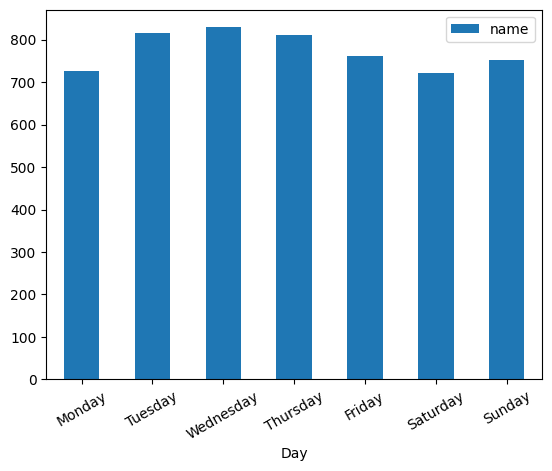

In [7]:
plot_pivot.plot.bar(x = 'Day', y = 'name', rot = 30)

**Wczytaj do projektu dane dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Połącz te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.**

In [8]:
usa_states = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations', header=0)[0]
usa_states=usa_states.iloc[:,[0,5]]
usa_states.rename(columns = {usa_states.columns[0]:'State', usa_states.columns[1]:'Code'}, inplace=True)
usa_states.dropna(axis=0, inplace=True)

In [11]:
usa_population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population', header = 0)[0]
usa_population = usa_population[{'State', 'Census population, April 1, 2010 [1][2]'}]
usa_population.rename(columns = {usa_population.columns[1]:'Population', usa_population.columns[0]:'State'}, inplace=True)

<ipython-input-11-ad890e2f8c14>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  usa_population = usa_population[{'State', 'Census population, April 1, 2010 [1][2]'}]


In [12]:
state_population_and_symbol = pd.merge(usa_population,usa_states,how='inner',on='State')
state_population_and_symbol.set_index(['Code'], inplace=True)

In [13]:
def assign_state_symbol(x):
  return state_population_and_symbol.loc[x,'Population']

def bonus(row):
  return round((row['victim'] / row['population']) * 1000, 2)

count = df.pivot_table(values = 'name', index = 'state', aggfunc = 'count')
count.rename(columns = {'name': 'victim'}, inplace=True)
count.reset_index(inplace = True)
count['population'] = count['state'].apply(lambda x: assign_state_symbol(x))
count['On 1000 case'] = count.apply(lambda row: bonus(row),axis = 1)
count


,state,victim,population,On 1000 case
0,AK,39,710231,0.05
1,AL,104,4779736,0.02
2,AR,83,2915918,0.03
3,AZ,254,6392017,0.04
4,CA,799,37253956,0.02
5,CO,195,5029196,0.04
6,CT,21,3574097,0.01
7,DC,13,601723,0.02
8,DE,13,897934,0.01
9,FL,350,18801310,0.02
